In [1]:
import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import isolearn.io as isoio
import isolearn.keras as iso

import scipy.optimize as spopt
from scipy.stats import pearsonr

from analyze_random_mpra_logistic_regression_helpers import *


Using TensorFlow backend.


In [2]:
#Load plasmid data
plasmid_dict = isoio.load('../data/random_mpra_legacy/combined_library/processed_data_lifted/apa_plasmid_data_legacy')
df = plasmid_dict['plasmid_df']

#Filter data on sublibrary TOMM5
keep_index = np.nonzero(df['library_index'].isin([2, 5, 8, 11, 20, 22]))[0]
df = df.iloc[keep_index].copy().reset_index(drop=True)

#Filter on min read count
keep_index = np.nonzero(df['total_count'] >= 1)[0]
df = df.iloc[keep_index].copy().reset_index(drop=True)

print('n = ' + str(len(df)))


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


n = 1994128


In [3]:
#Generate training and test set indexes
test_set_size=8000 * 6

plasmid_index = np.arange(len(df), dtype=np.int)

train_index = plasmid_index[:-test_set_size]
test_index = plasmid_index[train_index.shape[0]:]

print('Training set size = ' + str(train_index.shape[0]))
print('Test set size = ' + str(test_index.shape[0]))

Training set size = 1946128
Test set size = 48000


In [4]:
df = mask_constant_sequence_regions(df, add_padding=True)
df = align_on_cse(df)

In [5]:
#Initialize hexamer count data generator (separated by USE, CSE and DSE regions)

hexamer_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {
            'df' : df
        },
        batch_size=len(idx),
        inputs = [
            {
                'id' : 'use',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['seq_var_aligned'][:46],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            },
            {
                'id' : 'cse',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['seq_var_aligned'][50:56],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            },
            {
                'id' : 'dse',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['seq_var_aligned'][59:99],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            },
            {
                'id' : 'fdse',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['seq_var_aligned'][99:],
                'encoder' : iso.NMerEncoder(n_mer_len=6, count_n_mers=True),
                'sparse' : True,
                'sparse_mode' : 'col'
            },
            {
                'id' : 'lib',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['library_index'],
                'encoder' : iso.CategoricalEncoder(n_categories=36, categories=np.arange(36, dtype=np.int).tolist()),
                'sparsify' : True
            },
        ],
        outputs = [
            {
                'id' : 'proximal_usage',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : lambda row, index: row['proximal_count'] / row['total_count'],
                'transformer' : lambda t: t
            }
        ],
        randomizers = [],
        shuffle = False,
    ) for gen_id, idx in [('train', train_index), ('test', test_index)]
}

In [ ]:
#Generate hexamer occurrence count matrices and corresponding isoform proportions

[X_train_use, X_train_cse, X_train_dse, X_train_fdse, X_train_lib], y_train = hexamer_gens['train'][0]
y_train = y_train[0]

[X_test_use, X_test_cse, X_test_dse, X_test_fdse, X_test_lib], y_test = hexamer_gens['test'][0]
y_test = y_test[0]

In [ ]:
#Concatenate hexamer count matrices

X_train = sp.csc_matrix(sp.hstack([X_train_lib, X_train_use, X_train_cse, X_train_dse, X_train_fdse]))

X_test = sp.csc_matrix(sp.hstack([X_test_lib, X_test_use, X_test_cse, X_test_dse, X_test_fdse]))


In [ ]:
print("Starting logistic n-mer regression...")

w_init = np.zeros(X_train.shape[1] + 1)
lambda_penalty = 0

(w_bundle, _, _) = spopt.fmin_l_bfgs_b(log_loss, w_init, fprime=log_loss_gradient, args=(X_train, y_train, lambda_penalty), maxiter = 200)

print("Regression finished.")

#Collect weights
w_0 = w_bundle[0]
w_L = w_bundle[1:1 + 36]
w = w_bundle[1 + 36:]


In [13]:
#Store weights
data_version = 'all'
model_version = '6mer_v_pasaligned_margin'

w_bundle_no_lib = np.concatenate([np.array([w_0]), w], axis=0)

np.save('apa_regression_' + model_version + '_' + data_version + '_weights', w_bundle)

stored_nmer_weights = {
    'nmer' : [t[1] for t in sorted(hexamer_gens['train'].encoders['use'].encoder.decode_map.items(), key=lambda t: t[0])],
    'use' : w[: 4096].tolist(),
    'cse' : w[4096: 2 * 4096].tolist(),
    'dse' : w[2 * 4096: 3 * 4096].tolist(),
    'fdse' : w[3 * 4096: 4 * 4096].tolist(),
}

nmer_df = pd.DataFrame(stored_nmer_weights)
nmer_df = nmer_df[['nmer', 'use', 'cse', 'dse', 'fdse']]

nmer_df.to_csv('apa_regression_' + model_version + '_' + data_version + '_weights.csv', index=False, sep='\t')

In [ ]:
#Load weights
#data_version = 'all'
#model_version = '6mer_v_pasaligned_margin'
#w_bundle = np.load('apa_regression_' + model_version + '_' + data_version + '_weights.npy')

#Collect weights
#w_0 = w_bundle[0]
#w_L = w_bundle[1:1 + 36]
#w = w_bundle[1 + 36:]

Test set R^2 = 0.45, p = 0.0, n = 8000


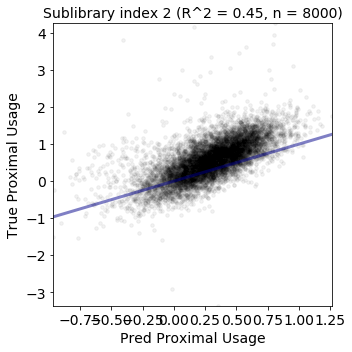

Test set R^2 = 0.5, p = 0.0, n = 8000


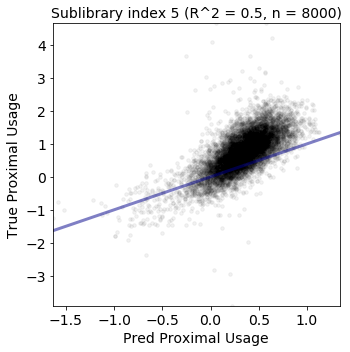

Test set R^2 = 0.39, p = 0.0, n = 8000


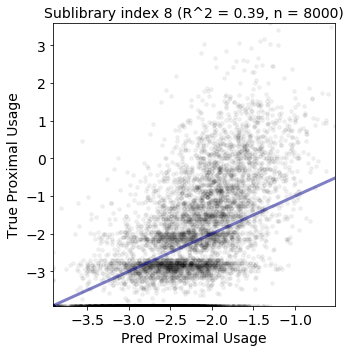

Test set R^2 = 0.47, p = 0.0, n = 8000


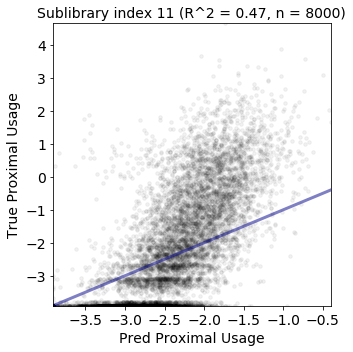

Test set R^2 = 0.63, p = 0.0, n = 8000


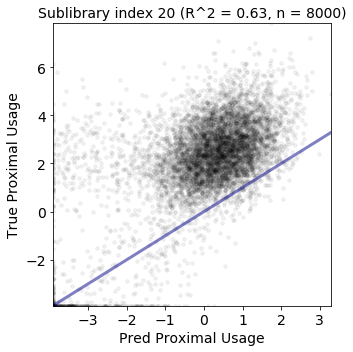

Test set R^2 = 0.52, p = 0.0, n = 8000


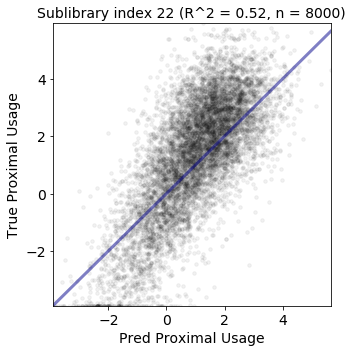

In [14]:
#Evaluate isoform logodds predictions on test set

def safe_log(x, minval=0.02):
    return np.log(x.clip(min=minval))

y_test_pred = get_y_pred(X_test, np.concatenate([w_L, w]), w_0)

for lib in [2, 5, 8, 11, 20, 22] :

    keep_lib = np.nonzero(X_test_lib[:, lib] == 1)[0]
    y_test_pred_lib = y_test_pred[keep_lib]
    y_test_lib = y_test[keep_lib]

    #Compute Log Odds values
    keep_index = (y_test_lib < 0.99999)
    y_test_valid = y_test_lib[keep_index]
    y_test_pred_valid = y_test_pred_lib[keep_index]

    logodds_test = np.ravel(safe_log(y_test_valid / (1. - y_test_valid)))
    logodds_test_pred = np.ravel(safe_log(y_test_pred_valid / (1. - y_test_pred_valid)))

    r_val, p_val = pearsonr(logodds_test_pred, logodds_test)

    print("Test set R^2 = " + str(round(r_val * r_val, 2)) + ", p = " + str(p_val) + ", n = " + str(y_test_pred_lib.shape[0]))

    #Plot test set scatter
    f = plt.figure(figsize=(5, 5))

    plt.scatter(logodds_test_pred, logodds_test, s = np.pi * (2 * np.ones(1))**2, alpha=0.05, color='black')
    min_x = max(np.min(logodds_test_pred), np.min(logodds_test))
    max_x = min(np.max(logodds_test_pred), np.max(logodds_test))
    min_y = max(np.min(logodds_test_pred), np.min(logodds_test))
    max_y = min(np.max(logodds_test_pred), np.max(logodds_test))
    plt.plot([min_x, max_x], [min_y, max_y], alpha=0.5, color='darkblue', linewidth=3)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.xlabel('Pred Proximal Usage', fontsize=14)
    plt.ylabel('True Proximal Usage', fontsize=14)

    plt.axis([np.min(logodds_test_pred), np.max(logodds_test_pred), np.min(logodds_test), np.max(logodds_test)])

    plt.title('Sublibrary index ' + str(lib) + ' (R^2 = ' + str(round(r_val * r_val, 2)) + ', n = ' + str(y_test_pred_lib.shape[0]) + ')', fontsize=14)

    plt.tight_layout()
    plt.show()